# Projet 5 : Segmentez des clients d'un site e-commerce
## Notebook de d'analyse et clustering

Ce notebook contient les étapes de sélection d'un modèle de clustering, l'évaluation de ses performances et l'interprétation de ses partitions.

### Chargement des librairies 

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.cm as cm
import warnings

# Nous nous basons sur la librairie RAPIDS qui propose une API similaire à scikit-learn mais permet de
# gagner beaucoup de temps en exécutant les calculs sur GPU
# https://rapids.ai/

import cudf
from cuml.cluster import KMeans
from cuml.cluster import DBSCAN
from cuml.cluster import AgglomerativeClustering
from cuml.manifold import TSNE 
from cuml.metrics.cluster import silhouette_score, silhouette_samples, adjusted_rand_score
from cuml import PCA

Lecture des données

In [72]:
data = cudf.read_csv('data_olist.csv',
                     sep = '\t') # Nous utilisons la date d'achat pour indexer les données

In [73]:
purchase_date = data.pop('order_purchase_timestamp')

In [74]:
# cuML fonctionne avec des dataframes différents, la conversion permet l'utilisation de l'API sklearn
pdData = data.to_pandas()

## Recherche d'un modèle pertinent 
Nous allons essayer différentes architectures de modèles d'apprentissage non-supervisés et mesurer leurs performances en fonction de plusieurs hyperparamètres.

### K-Means
Nous allons chercher le nombre de clusters maximisant la métrique de silhouette

In [75]:
nK = list(range(2,11))

In [76]:
silhouetteKMeans = []
Kmeans = []
for k in nK:
    model = KMeans(n_clusters=k)
    model.fit(data)
    Kmeans.append(model)
    silhouetteKMeans.append(silhouette_score(data,
                                            model.labels_,
                                            # Le calcul est effectué en plusieurs fois pour ne pas saturer la mémoire
                                            chunksize=15000)) 

In [77]:
plt.style.use('seaborn-darkgrid')

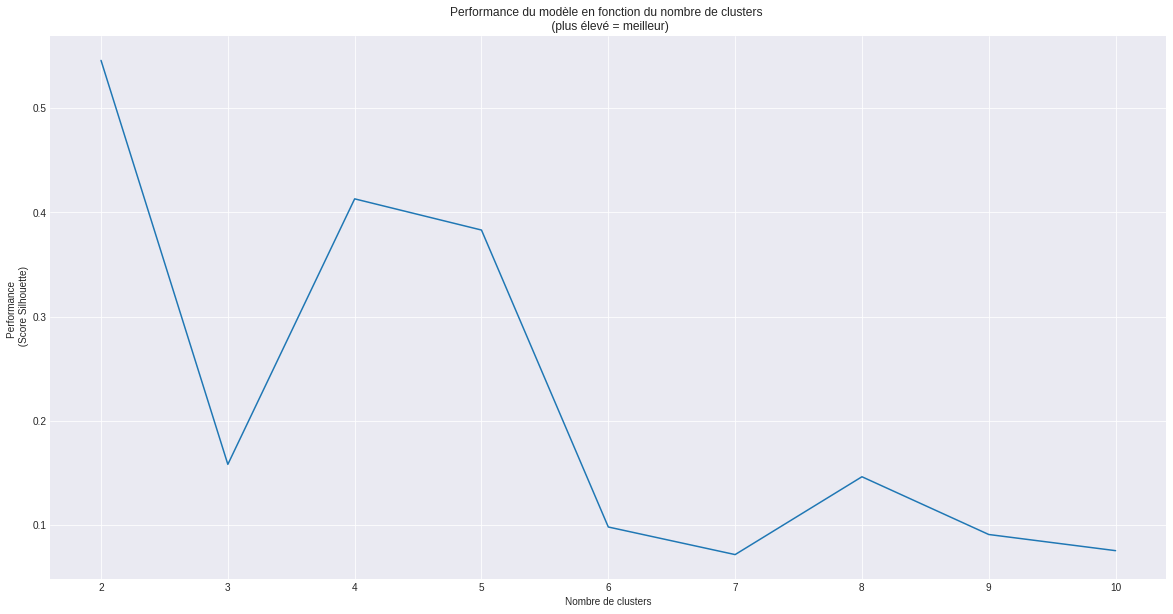

In [78]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Performance du modèle en fonction du nombre de clusters \n (plus élevé = meilleur)')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Performance \n (Score Silhouette)')
sns.lineplot(x=nK,
             y=silhouetteKMeans);

Nous pouvons repérer 3 pics du score pour 2, 4 et 8 clusters

Une analyse du contenu de ces clusters nous permettra de trancher sur le choix de combien en garder.

In [79]:
with warnings.catch_warnings():
    def plot_clusters(models,showLegend=True):
        
        n_models = len(models)
        fig, ax = plt.subplots(n_models,1,
                               figsize=(10,10*n_models))

        visualizer = TSNE(method='fft')
        X_tsne = visualizer.fit_transform(data)
        for i in range(0,n_models):

            sns.scatterplot(x=X_tsne.iloc[:,0].to_array(),
                            y=X_tsne.iloc[:,1].to_array(),
                            alpha = 0.6,
                            hue=models[i].labels_.to_array(),
                            palette=sns.color_palette("cubehelix",
                                                      n_colors=len(models[i].labels_.unique())),
                            legend=showLegend,
                            ax=ax[i]);
        
     
        
warnings.simplefilter("ignore") # Le warning nous previent juste que l'API est expérimentale    

[W] [14:33:49.859557] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


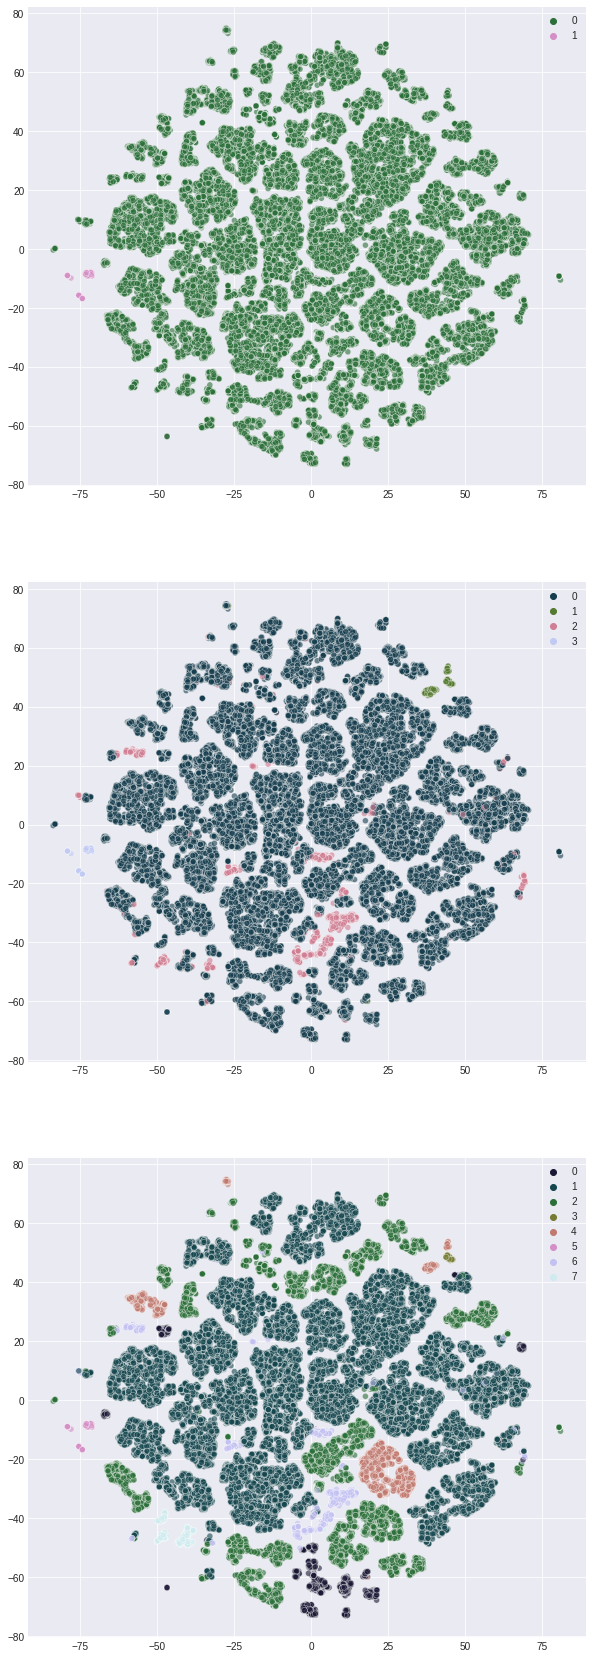

In [81]:
plot_clusters([Kmeans[i] for i in [0,2,6]])

La visualisation T-SNE ne met pas particulièrement en avant des partitions évidentes. 
- Nous pouvons en revanche observer une tendance à obtenir des clusters assez déséquilibrés.

### Clustering hiérarchique

In [ ]:
nK = list(range(2,11))
silhouetteTree = []
trees = []
for i in nK:
    model = AgglomerativeClustering(n_clusters=i)
    model.fit(data)
    trees.append(model)
    score = silhouette_score(data,
                             model.labels_,
                             chunksize=15000)
    silhouetteTree.append(score);

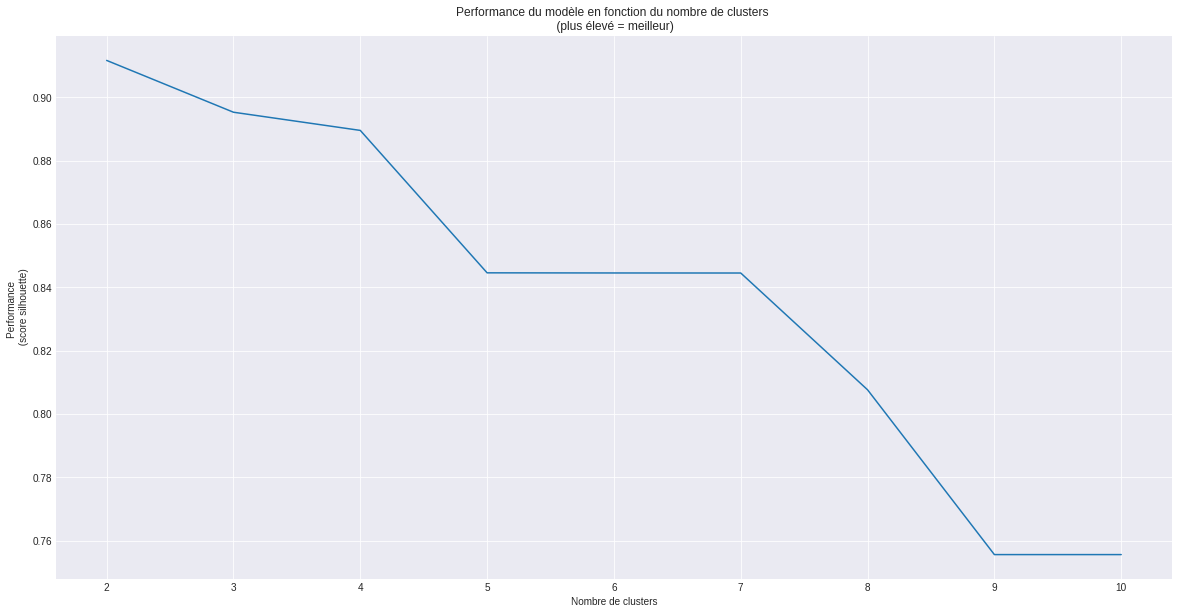

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Performance du modèle en fonction du nombre de clusters \n (plus élevé = meilleur)')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Performance \n (score silhouette)')
sns.lineplot(x=nK,
             y=silhouetteTree);

Ajouter plus de clusters que 2 semble seulement réduire la performance du modèle.

In [13]:
modelTree = AgglomerativeClustering(n_clusters=2)
modelTree.fit(data)

Label prop iterations: 12


AgglomerativeClustering()

Label prop iterations: 12
Label prop iterations: 11
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 4
Label prop iterations: 7
Label prop iterations: 3
Iterations: 8
7266,139,5482,19,301,1995
Label prop iterations: 2
Iterations: 1
1846,33,553,4,39,65


[W] [13:30:17.346716] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


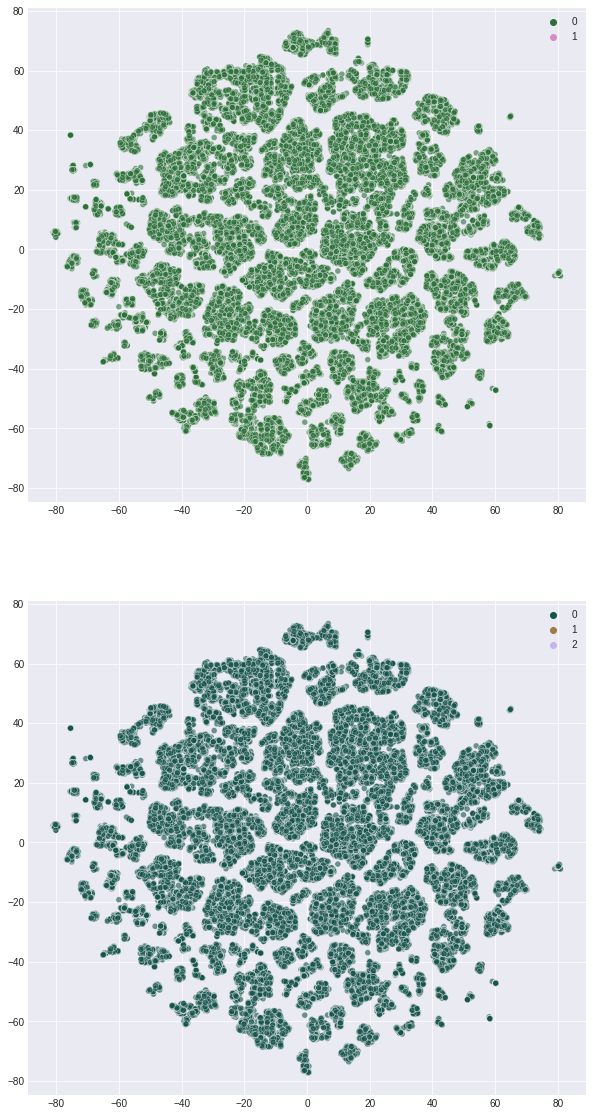

In [14]:
plot_clusters(trees[0:2])

L'algorithme n'a pas été en mesure de faire ressortir un partitionnage efficace, une écrasante majorité des données est contenue en 1 seul cluster. A chaque cluster que l'on ajoute, seulement 1 instance est classée dans cette partition.

In [15]:
trees[0].labels_.value_counts()

0    97915
1        1
dtype: int32

In [16]:
trees[1].labels_.value_counts()

0    97914
1        1
2        1
dtype: int32

In [17]:
trees[2].labels_.value_counts()

0    97913
1        1
2        1
3        1
dtype: int32

### DBSCAN

In [18]:
eps = np.arange(0.1,4,0.5)
silhouetteDBSCAN = []
DBSCANs = []
for i in eps:
    model = DBSCAN(eps=i)
    model.fit(data)
    DBSCANs.append(model)
    score = silhouette_score(data,
                             model.labels_,
                             chunksize=15000)
    silhouetteDBSCAN.append(score)

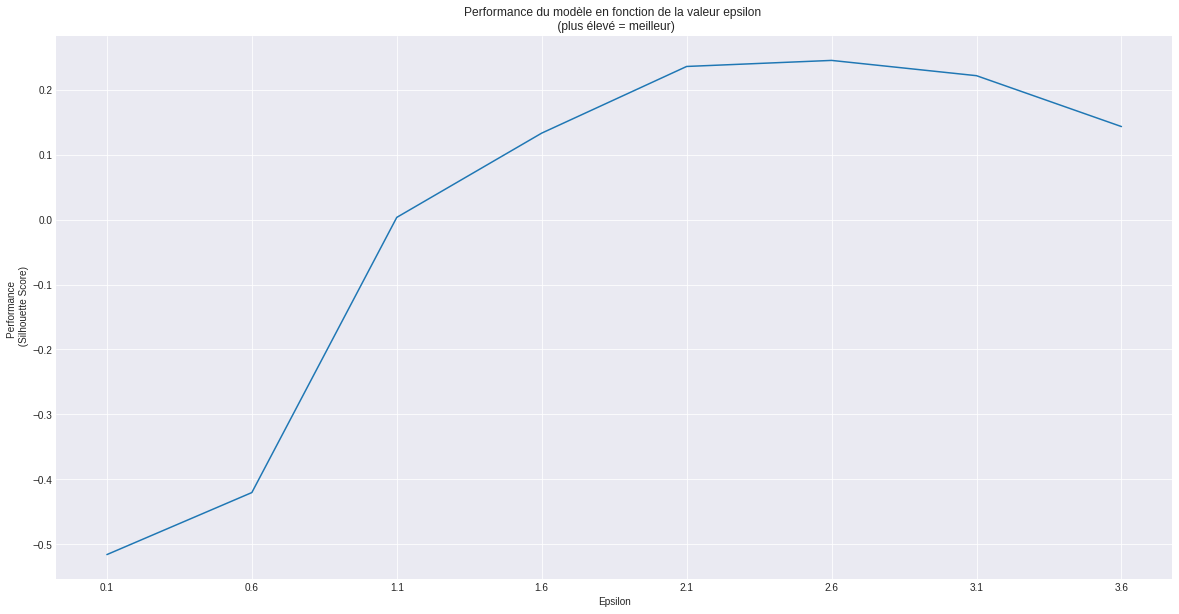

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_title('Performance du modèle en fonction de la valeur epsilon \n (plus élevé = meilleur)')
ax.set_xticks(eps)
ax.set_xlabel('Epsilon')
ax.set_ylabel('Performance \n (Silhouette Score)')
sns.lineplot(x=eps,
             y=silhouetteDBSCAN);

La meilleure valeur pour epsilon semble être aux alentours de 2.6

In [20]:
modelDbscan = DBSCAN(eps=2.6)
modelDbscan.fit(data)

DBSCAN()

In [21]:
print("Le modèle DBscan recence",
      len(modelDbscan.labels_.unique()),
      "clusters, trop pour une interprétation métier.")

Le modèle DBscan recence 159 clusters, trop pour une interprétation métier.


[W] [13:33:24.815315] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


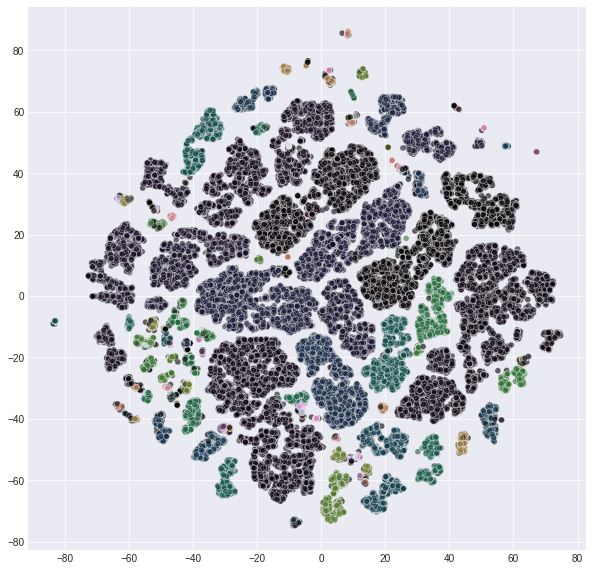

In [22]:
with warnings.catch_warnings():
        
        fig, ax = plt.subplots(1,1,
                               figsize=(10,10))

        visualizer = TSNE(method='fft')
        X_tsne = visualizer.fit_transform(data)

        sns.scatterplot(x=X_tsne.iloc[:,0].to_array(),
                            y=X_tsne.iloc[:,1].to_array(),
                            alpha = 0.6,
                            hue=modelDbscan.labels_.to_array(),
                            palette=sns.color_palette("cubehelix",
                                                      n_colors=len(modelDbscan.labels_.unique())),
                            legend=False,
                            ax=ax);
        
     
        
warnings.simplefilter("ignore") # Le warning nous previent juste que l'API est expérimentale    

Le partitionnage a une granularité trop élevée pour permettre une interprétation efficace.

### L'algorithme K-means s'est montré le plus performant pour ressortir des partitions exploitables.
- Nous allons nous baser sur son output pour le reste de cette analyse

## Interprétation des clusters par analyse factorielle

Calcul des composantes principales

In [23]:
pcaData = PCA(n_components = 2)
pcaData.fit(data)

PCA()

In [24]:
projection = (pcaData.fit_transform(data)).to_pandas()

Comme nous le démontrerons plus tard, il semblerait que 8 facteurs soient le partitionnage faisant le plus de sens d'un point de vue **métier**
- c'est donc ce nombre de clusters que nous choisissons de mettre en évidence sur le scatterplot

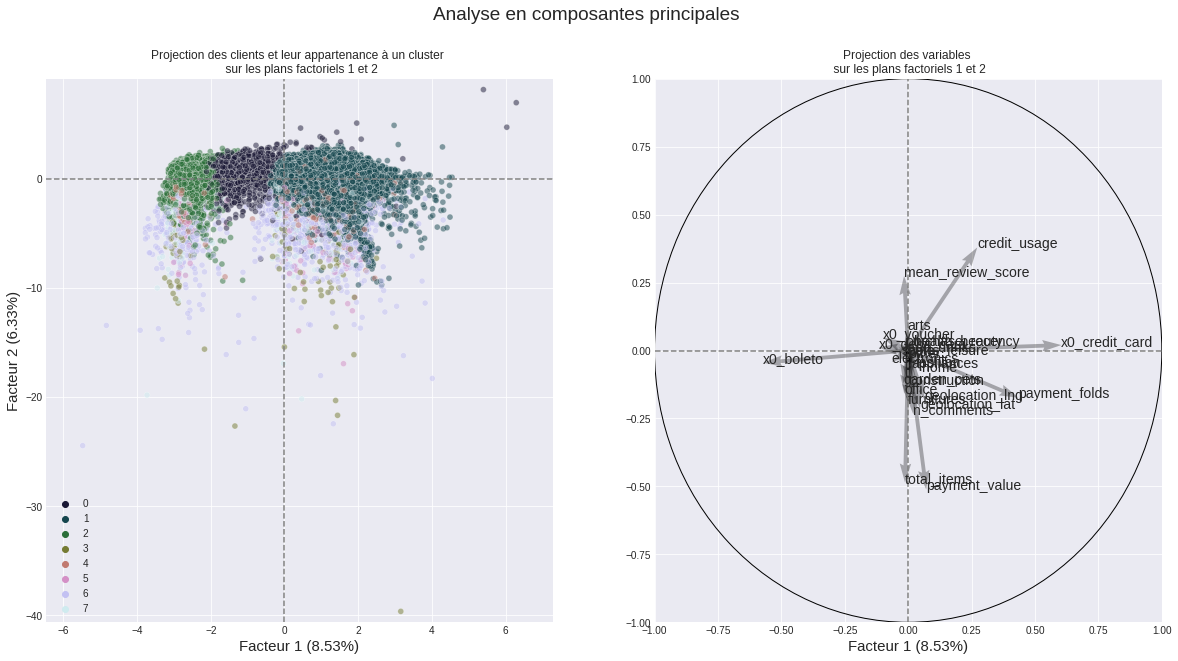

In [25]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
# titre général de la figure
fig.suptitle('Analyse en composantes principales',fontsize=19)

## sous figure 1 : projection des individus sur le plan factoriel

# nom des axes avec le pourcentage d'inertie (les deux sous graphes utilisent les mêmes noms d'axes)
xlabel = f'Facteur 1 ({np.round(pcaData.explained_variance_ratio_[0]*100,2)}%)'
ylabel = f'Facteur 2 ({np.round(pcaData.explained_variance_ratio_[1]*100,2)}%)'

# titre du sous graphique
ax[0].set_title(f'Projection des clients et leur appartenance à un cluster \n sur les plans factoriels 1 et 2')

# les individus projettés sur 2 plans factoriels
projection = (pcaData.fit_transform(data)).to_pandas()
                            
x_proj = projection[0]
y_proj = projection[1]

# définition des limites du graphe: légèrement plus grandes que les valeurs extrêmes
xMaxLim, xMinLim = x_proj.max() +1, x_proj.min() -1
yMaxLim, yMinLim = y_proj.max() +1, y_proj.min() -1
ax[0].set_xlim(xMinLim,xMaxLim)
ax[0].set_ylim(yMinLim,yMaxLim)

# définition des noms des axes pour la figure 1 
ax[0].set_xlabel(xlabel,fontsize=15)
ax[0].set_ylabel(ylabel,fontsize=15)

# construction du scatterplot
sns.scatterplot(x=x_proj,
                y=y_proj,
                alpha=0.5,
                hue = Kmeans[6].labels_.to_array(),
                palette= sns.color_palette("cubehelix", n_colors=len(Kmeans[6].labels_.unique())),
                ax=ax[0])

# on fait passer deux lignes au centre du nuage de points pour aider l'interprétation avec les flèches de la seconde figure
ax[0].plot([xMinLim,xMaxLim], [0, 0], color='grey', ls='--')
ax[0].plot([0, 0], [yMinLim,yMaxLim], color='grey', ls='--')


## sous figure 2 : projection des variables sur le plan factoriel

# definition du titre
ax[1].set_title(f'Projection des variables \n sur les plans factoriels 1 et 2')

# Le centre du cercle est défini par le croisement de deux lignes orthogonales représentant les axes des facteurs comme sur la sous figure 1
ax[1].plot([-1, 1], [0, 0], color='grey', ls='--')
ax[1].plot([0, 0], [-1, 1], color='grey', ls='--')

# définition des limites du graphe
ax[1].set_xlim(-1,1)
ax[1].set_ylim(-1,1)

# On ne précise que le label x car le label y est le même sur la sous figure 1 et partage le même axe horizontal
ax[1].set_xlabel(xlabel,fontsize=15)

# définition du cercle et ajout des flèches des varaibles en fonction de leur corrélation avec le facteur
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
ax[1].add_patch(circle)

Vt = pcaData.components_.to_pandas().values
# la matrice Vt contient dans chaque ligne les correlations de toutes les variables pour 1 facteur
# les lignes 1 et 2 correspondent aux correlations entre les variables et les facteurs 1 et 2 
ax[1].quiver(np.zeros(Vt.shape[1]),
             np.zeros(Vt.shape[1]),
             Vt[0,:],
             Vt[1,:],
             angles='xy',
             scale_units='xy',
             scale=1,
             alpha=0.3)

# Nous utilisons les coordonnés des flèches pour y annoter le nom de chaque variable et ainsi interpréter les flèches
for i in range(0,len(data.columns)):
    ax[1].text(Vt[0,i],Vt[1,i],
             data.columns[i],
             fontsize=14)

La principale découpe entre les points de données semble être due au mode de paiement privilégié. 
- Des outliers se distinguent sur un axe en diagonale en partant d'en bas à gauche où se trouvent probablement des clients ayant fait de grosses dépenses avec peu d'échéances et en haut à droite où de petites dépenses ont été réglées en plusieurs fois.
- de manière plus générale les points en bas du nuage semblent plus liés à de grosses commandes avec un prix élevé et beaucoup d'articles

#### Nous devons tout de même émettre une réserve quant à l'interprétation de cet espace qui ne **représente qu'une faible proportion de la variance des données**.

## Interprétation par visualisation 'radar'

La construction des données du plot est séparée de la fonction permettant de les afficher car il nous a été difficile de faire varier dynamiquement la quantité de 'radars' affichés par ligne et garder une bonne visibilité.

In [43]:
def calculate_plot(model):
    datawithKmeans = pdData.copy()
    datawithKmeans['cluster'] = model.labels_.to_array()
    
    clusterMeans = datawithKmeans.groupby('cluster').mean()
    # Contruction d'un angle par variable
    angles=np.linspace(0,2*np.pi,len(data.columns), endpoint=False)
    # Fermeture du cercle 
    angles=np.concatenate((angles,[angles[0]]))
    
    clusterLists = []
    for i in range(clusterMeans.shape[0]):
        circularDisplay = list(clusterMeans.iloc[i,:])
        circularDisplay.append(circularDisplay[0])
        clusterLists.append(circularDisplay)
        
        plotdatafeature = list(pdData.columns)
        plotdatafeature.append(plotdatafeature[0])
 
    return([clusterLists,angles,plotdatafeature])

In [44]:
k2 = calculate_plot(Kmeans[0])
k4 = calculate_plot(Kmeans[2])
k8 = calculate_plot(Kmeans[6])

In [45]:
def plot_radar(model,clusterData,interval):
    
    clusters = clusterData[0]
    angles = clusterData[1]
    plotdatafeature = clusterData[2]
    
    n_radar = interval[1] - interval[0]
    palette = sns.color_palette("cubehelix", n_colors=len(model.labels_.unique()))

    fig, ax = plt.subplots(1,n_radar,
               figsize=(30,10),
               subplot_kw=dict(polar=True))


    for i in range(0,n_radar):
        ax[i].set_title(f'Cluster {i+interval[0]}')

        ax[i].plot(angles,
                   clusters[i+interval[0]],
                   'o--', 
                   color=palette[i+interval[0]], 
                   label=i+interval[0])

        ax[i].fill(angles, 
                   clusters[i+interval[0]], 
                   alpha=0.25, 
                   color=palette[i+interval[0]])

        ax[i].set_thetagrids(angles * 180/np.pi, plotdatafeature)

## Pour 2 clusters

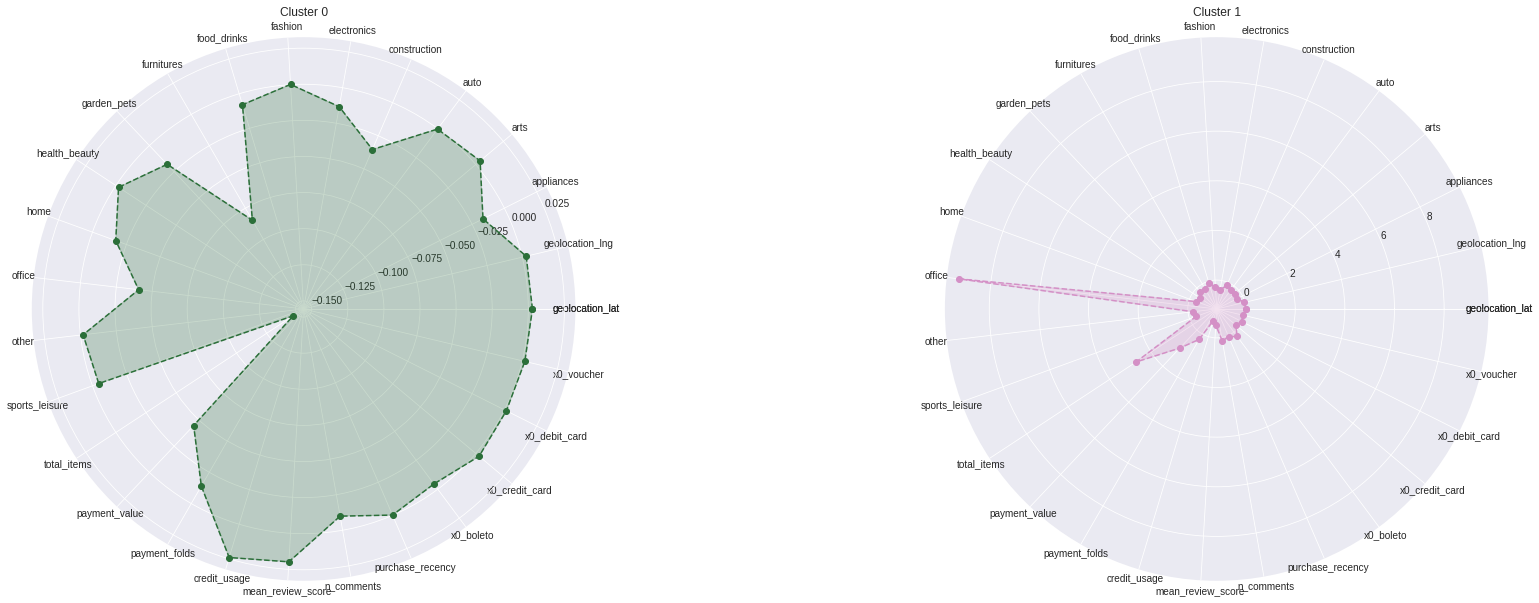

In [46]:
plot_radar(Kmeans[0],k4,(0,2))

Nous pouvons voir ici que le deuxième cluster représente des clients ayant acheté des fournitures de bureau.
- En revanche, le premier ne présente pas spécialement de critère distinctif.
- c'est pour cette raison que nous choisissons de considérer un nombre de K plus élevé.

## Pour 4 clusters

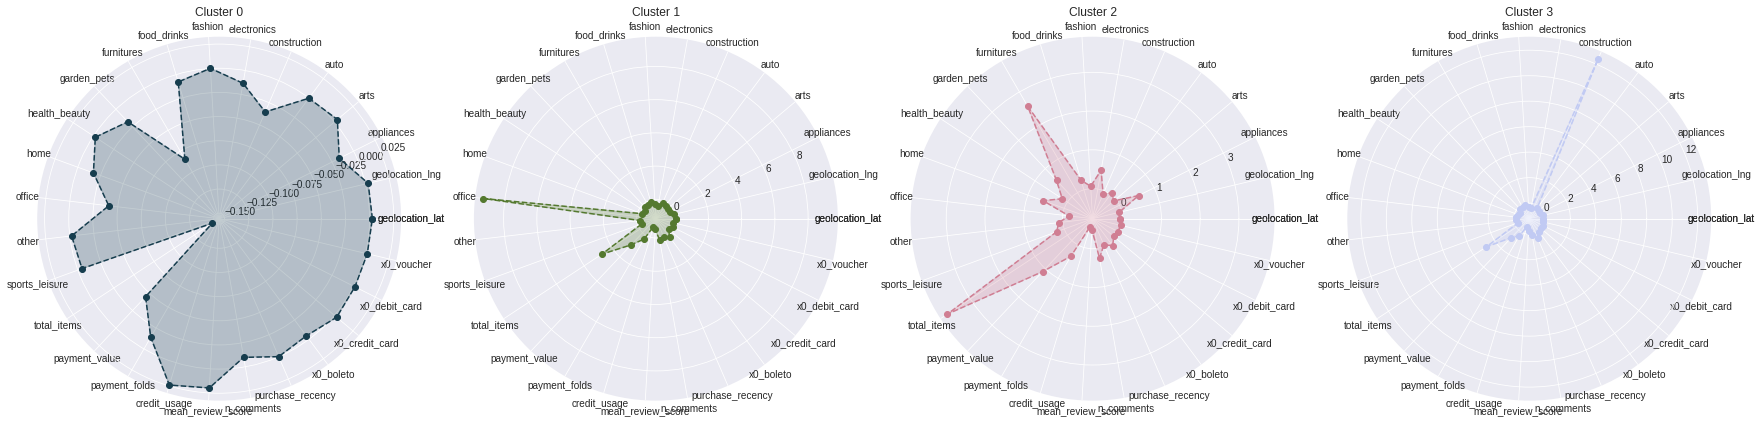

In [47]:
plot_radar(Kmeans[2],k4,(0,4))

Ici nous avons 3 types d'acheteurs qui se distinguent par les produits qui ont été commandés.
- cependant le problème du partitionnage vu plus haut subsiste toujours : Le premier cluster est trop générique pour être interprété.
- Nous augmentons le nombre de K à 8

## Pour 8 clusters

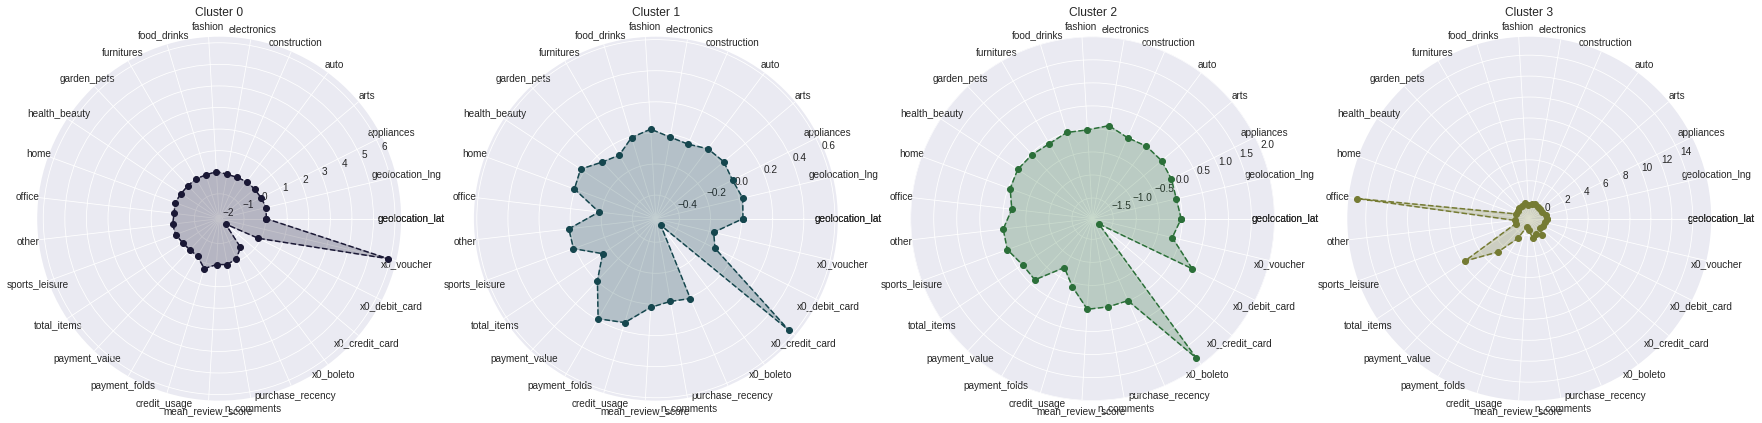

In [48]:
plot_radar(Kmeans[6],k8,(0,4))

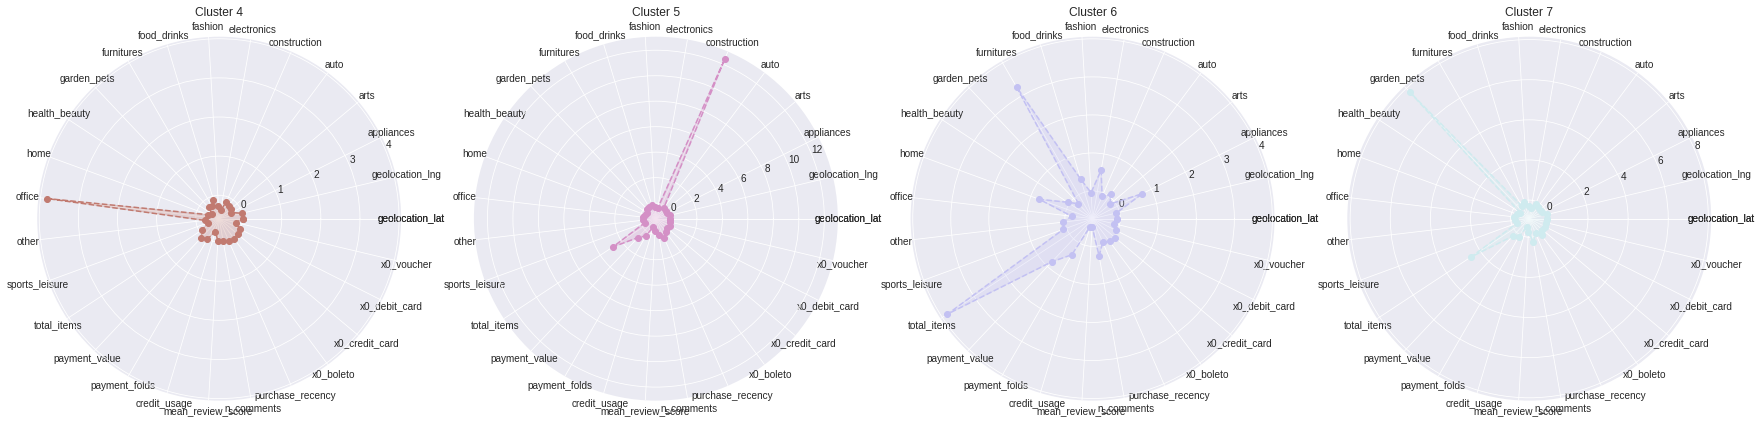

In [49]:
plot_radar(Kmeans[6],k8,(4,8))

Ici chaque cluster a un trait distinctif.
- plus précisément, le 0, 1 et 3 semblent représenter les modes de paiements qui ont étés privilégiés par les clients
- les autres (3,4,5,6,7) sont chacun liés à une catégorie spécifique de produits.

### Actions marketing

Il nous est possible de proposer des actions marketing pour ces partitions :

Les clusters 3,4,5,6 et 7 représentent des clients intéressés par une certaine catégorie de produits.

- Grâce à ces informations il serait possible de cibler des publicités sur des produits proches de ceux qu'ils ont l'habitude d'acheter.

En ce qui concerne les 3 premieres partitions elles représentent les moyens de paiement privilégiés par les clients

Les décisions marketing ici dépendent des avantages de l'entreprise vis-à-vis de chaque méthode de paiement :
- Si par exemple la carte de crédit est la méthode que la plateforme préfère il serait possible de proposer aux clients membres des clusters 0 et 2 des réductions à condition qu'ils utilisent une carte de crédit pour leur achat.

# Stabilité des clusters

Nous allons calculer la stabilité de notre clustering sur la base d'une simulation d'arrivée de données nouvelles:

L'objectif de cette manipulation est de voir combien de temps notre modélisation serait capable de fournir des prédictions pertinentes avant de nécessiter d'être entrainée à nouveau.

- nous partons d'une année du dataset
- nous entrainons notre modèle sur 6 mois de données
- petit à petit nous ajoutons des semaines pour voir combien de temps le partitionnage reste pertinent avant réentrainement.

A chaque fois qu'une semaine est ajoutée, nous récupérons les labels qui ont été prédits sur les 6 premiers mois et les comparons aux labels qui avaient été prédits quand les données n'étaient pas encore 'arrivées'.

- cette comparaison est faite avec l'Adjusted Rand Score et va nous permettre de mesurer à quel point un client va se retrouver dans des clusters différents.

In [50]:
pdData.index = pd.to_datetime(purchase_date.to_pandas())

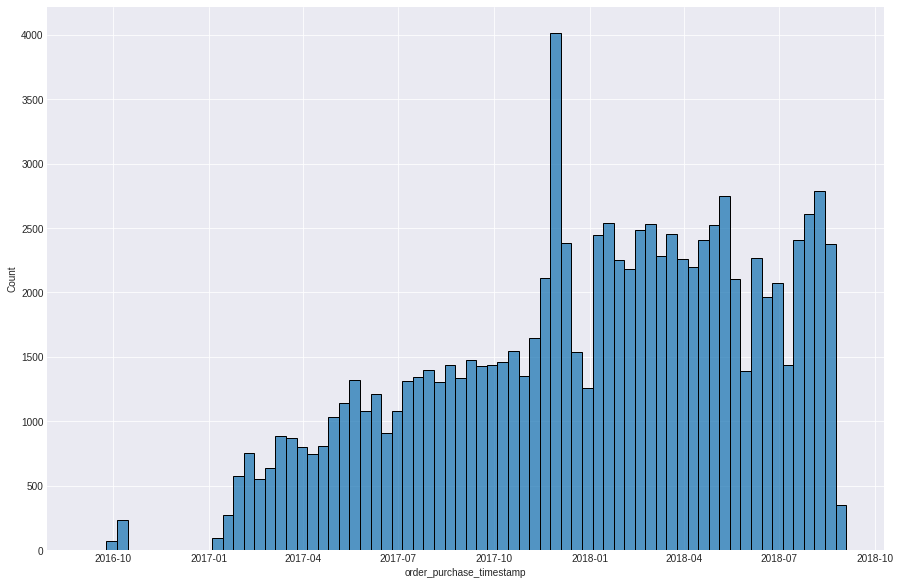

In [51]:
plt.figure(figsize=(15,10))
sns.histplot(pdData.index);

L'année 2017 semble être la seule comprise dans son entièreté, nous allons nous baser sur celle-ci pour l'estimation de la stabilité.

In [133]:
# On prend les 6 premiers mois de 2017 pour l'entrainement
trainingMonths = cudf.DataFrame(pdData.loc['2017-01':'2017-06'])

In [134]:
# Faire un sort des données évite des erreurs de pandas lors de l'indexage par periodes de temps
pdData.sort_index(inplace=True)

In [135]:
# On découpe en semaines les 6 mois restants de l'année 2017
grouped_data = pdData.loc['2017-07':'2017-12'].resample('W')
keys = list(grouped_data.groups.keys())

In [136]:
# On crée une liste contenant une semaine de données par entrée
incrementalWeeks = []
for i in range(0,16):
    partialData = grouped_data.get_group(keys[i])
    incrementalWeeks.append(cudf.DataFrame(partialData))

In [137]:
# On crée le modèle
modelStabilityTest = KMeans(n_clusters=8)

In [138]:
# La première entrée est le score parfait calculé sur les mêmes labels
labelsList = [modelStabilityTest.fit_predict(trainingMonths.append(incrementalWeeks[0]))]

# Pour chaque calcul de l'ARI suivant on concatene les 6 mois + 1 puis 2 puis 3 semaines
# On fait une prédiction à chaque mois + n semaines 
for i in range(1,16): 
    cumulativeData = trainingMonths.append(cudf.concat(incrementalWeeks[0:i]))
    labelsList.append(modelStabilityTest.fit_predict(cumulativeData))

In [139]:
# Le score ARI est alors calculé sur ces intervalles de temps de plus en plus grands
ARIscores = [adjusted_rand_score(labelsList[0],
                                 labelsList[i][0:len(labelsList[0])]) for i in range(1,len(labelsList))]

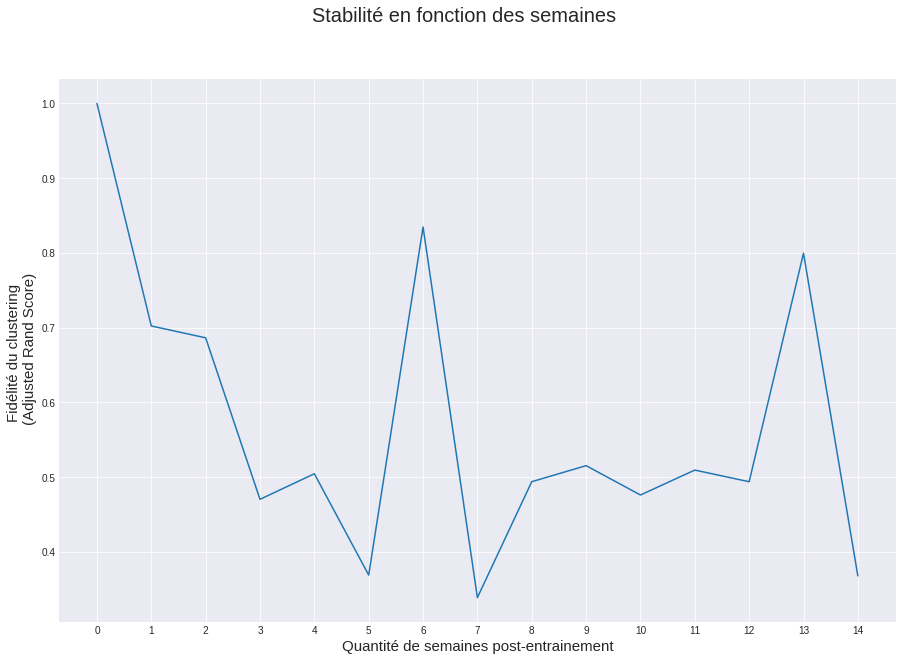

In [141]:
plt.figure(figsize=(15,10))
sns.lineplot(x = range(0,len(ARIscores)),
             y = ARIscores)
plt.xticks(list(range(0,len(ARIscores))))
plt.suptitle('Stabilité en fonction des semaines',
             fontsize=20)
plt.xlabel('Quantité de semaines post-entrainement',
           fontsize=15)
plt.ylabel('Fidélité du clustering \n (Adjusted Rand Score)',
           fontsize=15);

Au point 0 nous comparons les attributions de labels sans ajouter de données, le score est parfait.
- Lorsqu'une semaine est ajoutée le score chute aux alentours de 0.7
- à 2 semaines le score baisse légèrement mais reste proche des 0.7
- arrivé à 3 semaines nous perdons fortement en fidélité aux données de départ
- au delà de ce point la métrique baisse et monte de manière aléatoire : nous ne pouvons plus considérer le clustering stable

## Au vu de cette analyse nous avançons qu'un ré-entrainement du modèle est nécessaire toutes les 2 semaines